# Task

Keep using the One-piece [competition case](https://www.kaggle.com/t/f5f7783abf31495f9593b3d93a18f9eb).

Build on your Assignment 3.

1. Keep improving some ideas that were not explored before.
1. Week 8 will talk about PCA as a simple summary of many variables.
1. Get the test sample for prediction and submit your results on Kaggle to get your Kaggle score screenshot. Show the screenshot in the PDF file.

**Note:**
- All instructions in Assignment 1 apply.
- Use $\leq 300$ words.

## Install Packages

In [65]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  Lasso, LinearRegression,LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from itertools import combinations
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut

## 1. Read Data

In [66]:
train_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/train_data.csv"
train_df = pd.read_csv(train_url)
test_url = "https://github.com/joshcpld/ada/raw/main/Assignment%202/data/test_data.csv"
test_df = pd.read_csv(test_url)

train_df.head()

,ID,Y,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0,-1.399091,1.174139,1.413109,0.164693,-1.067338,0.015324,-1.280970,0.489681,-0.371982,...,-0.115044,-2.580043,-0.812428,0.772820,-0.460444,0.190422,-0.362052,-1.119038,0.916313,-1.517434
1,1,3.097990,0.208922,0.931231,0.838779,0.893483,-0.510555,0.900289,-0.042490,0.839400,...,1.155635,0.673035,-0.438152,-0.001316,-0.761800,1.335092,0.901978,-1.549504,-0.456224,0.223405
2,2,-1.707346,-0.744982,0.962118,0.615392,-0.427943,-0.014912,1.138781,1.159491,0.055467,...,0.299277,1.387495,-0.007519,-0.464825,0.830986,0.373124,0.319232,-0.577295,-1.363846,-0.347154
3,3,0.610625,-0.170428,-1.361771,0.206042,0.623124,0.907441,-0.873814,1.287383,0.901191,...,1.209247,0.095866,-0.287905,-1.110714,-1.660352,0.207231,-0.419119,-0.517563,-1.050697,-0.096327
4,4,-0.689196,-0.858792,0.321308,-0.415649,1.014056,-0.522858,0.926634,-0.390663,0.790054,...,-1.191989,-1.127448,0.246358,0.407769,1.132454,-0.016621,0.964745,0.091532,0.649593,-0.818020


First, we separate the X predictors from our outcome variable Y.

In [67]:
# Separate the X predictors and Y outcome variable
X0_train = train_df.drop(columns=['Y', 'ID'])
y0_train = train_df['Y'].values
x0_test = test_df.drop(columns=["ID"])
cols = X0_train.columns.tolist()

## 2a. PCA

K by 95% explained variance threshold: k_ev = 47 (out of p = 50)


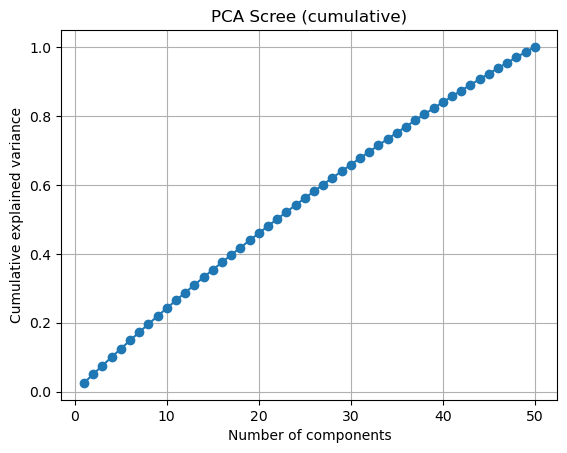

In [68]:
# Standardize X then fit PCA on X_train
scaler = StandardScaler()
X_train_scaled_pca = scaler.fit_transform(X0_train)
X_test_scaled_pca  = scaler.transform(x0_test)

feature_names = X0_train.columns.tolist()
n, p = X0_train.shape

pca = PCA() 
pca.fit(X_train_scaled_pca)

cumexp = np.cumsum(pca.explained_variance_ratio_)
k_ev = int(np.argmax(cumexp >= 0.95) + 1)  # K that reaches ≥95% variance
print(f"K by 95% explained variance threshold: k_ev = {k_ev} (out of p = {p})")

# Scree (cumulative) — optional diagnostic plot
plt.figure()
plt.plot(np.arange(1, len(cumexp)+1), cumexp, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Scree (cumulative)")
plt.grid(True)
plt.show()

Pick K by Leave-One-Out CV

In [69]:
max_k = int(min(30, p))
Z_train = pca.transform(X_train_scaled_pca)

loo = LeaveOneOut()
mse_by_k = []

for k in range(1, max_k+1):
    lr = LinearRegression()
    fold_mse = []
    for tr, va in loo.split(Z_train):
        lr.fit(Z_train[tr, :k], y0_train[tr])
        yhat = lr.predict(Z_train[va, :k])
        fold_mse.append(mean_squared_error(y0_train[va], yhat))
    mse_by_k.append(np.mean(fold_mse))

k_loo = int(np.argmin(mse_by_k) + 1)
print(f"Best K by LOOCV (1..{max_k}): k_loo = {k_loo} with MSE = {mse_by_k[k_loo-1]:.6f}")

Best K by LOOCV (1..30): k_loo = 30 with MSE = 9.138519


Fit PCA with K chosen by LOOCV

In [70]:
lr_final = LinearRegression().fit(Z_train[:, :k_loo], y0_train)

# Predictions for the test set
Z_test = pca.transform(X_test_scaled_pca)
y_pred_test_pca = lr_final.predict(Z_test[:, :k_loo])

## 2b. LASSO Regularisation with K-fold CV

In this section, we begin with LASSO regularisation to reduce our parameter scope using cross-validation.

Second, we then create a matrix of higher order polynomial and interaction terms.

In [71]:
# Define function
def matrix(df, cols, max_order=4):
    # Original terms: X1, X2, X3, ..., X50
    base = df[cols].copy()

    # Higher-order polynomial terms
    poly_dfs = []
    for order in range(2, max_order + 1):
        if order == 2:
            # Squared terms: X1^2, X2^2, X3^2, ..., X50^2
            poly_df = pd.DataFrame({f"{c}^2": df[c]**2 for c in cols}, index=df.index)
        elif order == 3:
            # Cubic terms: X1^3, X2^3, X3^3, ..., X50^3
            poly_df = pd.DataFrame({f"{c}^3": df[c]**3 for c in cols}, index=df.index)
        elif order == 4:
            # Quartic terms: X1^4, X2^4, X3^4, ..., X50^4
            poly_df = pd.DataFrame({f"{c}^4": df[c]**4 for c in cols}, index=df.index)
        else:
            # Higher orders: X1^n, X2^n, etc.
            poly_df = pd.DataFrame({f"{c}^{order}": df[c]**order for c in cols}, index=df.index)
        poly_dfs.append(poly_df)

    # Interaction terms: X1*X2, X1*X3, ..., X49*X50
    components_to_concat = [base] + poly_dfs
    
    inter_dict = {}
    for i, c1 in enumerate(cols):
        for j in range(i+1, len(cols)):
            c2 = cols[j]
            inter_dict[f"{c1}*{c2}"] = df[c1] * df[c2]
    inter = pd.DataFrame(inter_dict, index=df.index)
    components_to_concat.append(inter)

    # Combine all together
    X_vars = pd.concat(components_to_concat, axis=1)
    return X_vars

# Create the polynomial and interaction terms training set
# Set 1: Up to quadratic
X_vars_train_quad = matrix(train_df, cols, max_order=2)
X_vars_test_quad = matrix(x0_test, cols, max_order=2)

# Set 2: Up to cubic
X_vars_train_cubic = matrix(train_df, cols, max_order=3)
X_vars_test_cubic = matrix(x0_test, cols, max_order=3)

# Set 3: Up to quartic
X_vars_train_quartic = matrix(train_df, cols, max_order=4)
X_vars_test_quartic = matrix(x0_test, cols, max_order=4)

# Display feature counts for different approaches
print("Feature counts by polynomial order:")
print(f"Linear: {len(cols)}")
print(f"Quadratic + interactions: {X_vars_train_quad.shape[1]}")
print(f"Cubic + interactions: {X_vars_train_cubic.shape[1]}")
print(f"Quartic + interactions: {X_vars_train_quartic.shape[1]}")

Feature counts by polynomial order:
Linear: 50
Quadratic + interactions: 1325
Cubic + interactions: 1375
Quartic + interactions: 1425


Third, we create dictionary of feature sets

In [72]:
feature_sets = {
    'Quadratic': {
        'X_train': X_vars_train_quad,
        'X_test': X_vars_test_quad,
        'description': 'Quadratic polynomials + interactions'
    },
    'Cubic': {
        'X_train': X_vars_train_cubic,
        'X_test': X_vars_test_cubic,
        'description': 'Cubic polynomials + interactions'
    },
    'Quartic': {
        'X_train': X_vars_train_quartic,
        'X_test': X_vars_test_quartic,
        'description': 'Quartic polynomials + interactions'
    }
}

all_selected_predictors = {}
all_lasso_features = {}
feature_set_performance = {}

Fourth, we evaluating different polynomial orders with LASSO regularisation

In [73]:
for set_name, feature_data in feature_sets.items():
    print(f"\n{set_name}: {feature_data['description']}")
    print(f"Feature count: {feature_data['X_train'].shape[1]}")

    # Scale the predictors to ensure comparability.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(feature_data['X_train'].values)

    # Fourth, we select the 'optimal' alpha for LASSO regularisation 
    # (which we combine with cross-validation).

    lasso_cv_model = LassoCV(alphas=np.logspace(-5, 2, num=100), cv=10, max_iter=10000)

    # Fit the LassoCV model to the scaled training data
    lasso_cv_model.fit(X_train_scaled, y0_train)

    # The optimal alpha selected by cross-validation
    optimal_alpha_lasso = lasso_cv_model.alpha_
    print("Optimal Alpha:", optimal_alpha_lasso)

    # As we are interested in a range of models, 
    # and want to see which set of models perform the best, 
    # let us select a range of alphas one standard error from our optimal point.

    # Get the mean CV error per alpha
    mean_mse = lasso_cv_model.mse_path_.mean(axis=1)

    # Calculate the standard error of the mean CV error
    std_mse = lasso_cv_model.mse_path_.std(axis=1) / np.sqrt(lasso_cv_model.mse_path_.shape[1])

    # Index of best alpha
    optimal_alpha_lasso_index = np.where(lasso_cv_model.alphas_ == optimal_alpha_lasso)[0][0]

    # Create a threshold using one standard error from the mean CV error of the optimal alpha
    alpha_threshold = mean_mse[optimal_alpha_lasso_index] + std_mse[optimal_alpha_lasso_index]

    # Apply this threshold to select a set of alphas
    threshold_inequality = mean_mse <= alpha_threshold
    selected_alphas = lasso_cv_model.alphas_[threshold_inequality]

    # Use LASSO on these set of alphas to select a set of features for our multiple linear regression model
    LASSO_features = {}
    for a in selected_alphas:
        model = Lasso(alpha=a).fit(X_train_scaled, y0_train)
        LASSO_features[a] = model
        n_predictors = np.sum(model.coef_ != 0)
        print(f"alpha={a:.5f} | predictors={n_predictors}")

    # Extract selected predictors from each LASSO model
    selected_predictors = {}
    model_counter = 1

    for alpha, lasso_model in LASSO_features.items():
    # Get the selected feature names
        selected_features = feature_data['X_train'].columns[lasso_model.coef_ != 0].tolist()

    
    # Store in dictionary with model name
        selected_predictors[f"Model {model_counter}"] = selected_features
        model_counter += 1

    # Print summary of selected features for each model
    print(f"\nSelected features summary for {set_name}:")
    for model_name, features in selected_predictors.items():
        print(f"{model_name}: {len(features)} predictors selected")

    # Store results for this feature set
    all_selected_predictors[set_name] = selected_predictors
    all_lasso_features[set_name] = {
        'models': LASSO_features,
        'scaler': scaler,
        'optimal_alpha': optimal_alpha_lasso,
        'selected_alphas': selected_alphas
    }
    
    # Store performance metrics for comparison
    feature_set_performance[set_name] = {
        'optimal_alpha': optimal_alpha_lasso,
        'min_cv_error': mean_mse[optimal_alpha_lasso_index],
        'n_models': len(selected_alphas),
        'feature_count': feature_data['X_train'].shape[1]
    }
    


Quadratic: Quadratic polynomials + interactions
Feature count: 1325
Optimal Alpha: 0.06579332246575675
alpha=0.09112 | predictors=88
alpha=0.07743 | predictors=129
alpha=0.06579 | predictors=186
alpha=0.05591 | predictors=234
alpha=0.04751 | predictors=300

Selected features summary for Quadratic:
Model 1: 88 predictors selected
Model 2: 129 predictors selected
Model 3: 186 predictors selected
Model 4: 234 predictors selected
Model 5: 300 predictors selected

Cubic: Cubic polynomials + interactions
Feature count: 1375
Optimal Alpha: 0.06579332246575675
alpha=0.10723 | predictors=58
alpha=0.09112 | predictors=89
alpha=0.07743 | predictors=134
alpha=0.06579 | predictors=191
alpha=0.05591 | predictors=246
alpha=0.04751 | predictors=318

Selected features summary for Cubic:
Model 1: 58 predictors selected
Model 2: 89 predictors selected
Model 3: 134 predictors selected
Model 4: 191 predictors selected
Model 5: 246 predictors selected
Model 6: 318 predictors selected

Quartic: Quartic poly

Fifth, we identifies which polynomial order has lowest cross-validation error

In [74]:
# Display comparison table
perf_df = pd.DataFrame.from_dict(feature_set_performance, orient='index')[
    ['feature_count', 'n_models', 'optimal_alpha', 'min_cv_error']
]

print("\n=== CV summary by feature set ===")
print(perf_df.sort_values('min_cv_error').round({'optimal_alpha': 6, 'min_cv_error': 6}))

# Identify best feature set based on CV error
best_set = perf_df['min_cv_error'].idxmin()
print(f"\nBest set is {best_set}: {feature_sets[best_set]['description']}")

selected_predictors = all_selected_predictors[best_set]
LASSO_features = all_lasso_features[best_set]['models']
print(f"Models to average: {len(selected_predictors)}")



=== CV summary by feature set ===
           feature_count  n_models  optimal_alpha  min_cv_error
Quadratic           1325         5       0.065793      4.686437
Quartic             1425         5       0.065793      4.698392
Cubic               1375         6       0.065793      4.703243

Best set is Quadratic: Quadratic polynomials + interactions
Models to average: 5


Sixth, we also explore LOWESS method to capture local trends that may not be captured by our polynomial regression models.

In [75]:
# Use the best performing feature set
X_vars_train = feature_sets[best_set]['X_train']
X_vars_test = feature_sets[best_set]['X_test']

# Select a key predictor for threshold analysis
# Using most frequently selected feature
feature_frequency = {}
for model_name, features in selected_predictors.items():
    for feature in features:
        feature_frequency[feature] = feature_frequency.get(feature, 0) + 1

sorted_features = sorted(feature_frequency.items(), key=lambda x: x[1], reverse=True)

if sorted_features:
    key_predictor = sorted_features[0][0]
    print(f"Selected most frequent feature: {key_predictor} (appears in {feature_frequency[key_predictor]} models)")
else:
    print("No features found for key predictor.")

# Determine threshold value (median)
threshold_value = X_vars_train[key_predictor].median()

# Create above and below indices
above_indices = X_vars_train[key_predictor] >= threshold_value
below_indices = X_vars_train[key_predictor] < threshold_value

# Fit LOWESS models for above and below data
fit_above = sm.nonparametric.lowess(y0_train[above_indices], X_vars_train.loc[above_indices, key_predictor])
fit_below = sm.nonparametric.lowess(y0_train[below_indices], X_vars_train.loc[below_indices, key_predictor])

# Generate range of values for prediction
x_min, x_max = X_vars_train[key_predictor].min(), X_vars_train[key_predictor].max()
rr = np.linspace(x_min, x_max, num=100)

# Predictions for above and below data
pred_above = np.interp(rr, fit_above[:, 0], fit_above[:, 1])
pred_below = np.interp(rr, fit_below[:, 0], fit_below[:, 1])

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=rr, y=pred_above, mode='lines', 
                        line=dict(color='blue', width=2), name='Above Threshold'))
fig.add_trace(go.Scatter(x=rr, y=pred_below, mode='lines', 
                        line=dict(color='red', width=2), name='Below Threshold'))

fig.update_layout(
    xaxis_title=key_predictor,
    yaxis_title="Y (Outcome)",
)

fig.show()

print(f"LOWESS reveals different local trends above and below {key_predictor} = {threshold_value:.3f}")

Selected most frequent feature: X1 (appears in 5 models)


LOWESS reveals different local trends above and below X1 = 0.029


The LOWESS confirmed the presence of nonlinear relationships that justify the polynomial regression approach

In this section, we attempt to select which combination of multiple linear regression models performs best on the training data. The average of the model combinations that perform the best will be selected for our model prediction.

In [76]:
# Create 5 fold CV to evaluate the performance of each model combination
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
model_names = list(selected_predictors.keys())
cv_mse = {}

# Loop through all combinations of models
for i in range(1, len(model_names) + 1):
    for x in combinations(model_names, i): # Generate all combinations of model names of size i
        fold_mse = [] # Store the MSE for each fold
        for train_idx, val_idx in k_fold.split(X_vars_train):
            y_train, y_val = y0_train[train_idx], y0_train[val_idx] # Split the training data into training and validation subsets
            preds = [] # Store each of the predictions into this vector
            for name in x: # Loop through each model in the combination
                X_train = X_vars_train.iloc[train_idx][selected_predictors[name]] # Obtain the predictors for the training model
                X_val   = X_vars_train.iloc[val_idx][selected_predictors[name]] # Obtain the predictors for the validation model
                m = LinearRegression().fit(X_train, y_train) # Fit the multiple linear regression model on the training subset
                preds.append(m.predict(X_val)) # Predict the validation subset and store the predictions
            avg_pred = np.column_stack(preds).mean(axis=1) # Average the prediction from each model combination
            fold_mse.append(mean_squared_error(y_val, avg_pred)) # Compute the MSE for this fold and then store it
        cv_mse[x] = np.mean(fold_mse) # Once each fold is complete, average the MSE folds to get the CV error for this model combination

sorted_cv_mse = sorted(cv_mse.items(), key=lambda x: x[1]) # Sort the model combinations by the smallest CV error
cv_mse_df = pd.DataFrame(sorted_cv_mse, columns=["Models", "CV_MSE"]) # Store the results into a dataframe
cv_mse_df

,Models,CV_MSE
0,"(Model 1, Model 4, Model 5)",3.745852
1,"(Model 1, Model 2, Model 4, Model 5)",3.750419
2,"(Model 1, Model 3, Model 5)",3.754361
3,"(Model 1, Model 3, Model 4, Model 5)",3.754469
4,"(Model 1, Model 5)",3.758442
5,"(Model 1, Model 2, Model 3, Model 4, Model 5)",3.758829
6,"(Model 2, Model 4, Model 5)",3.770804
7,"(Model 1, Model 2, Model 3, Model 5)",3.770859
8,"(Model 2, Model 5)",3.774660
9,"(Model 1, Model 2, Model 5)",3.774787


Given that the combination of Model 1, 4, and 5 performs the best. We will use this combination for our final prediction set.

## 3. Model Prediction

In this section, for lasso model we will average the predictions from Model 1, 4, and 5 for our test set.

In [77]:
# Select the models of interest
models_to_use = ["Model 1", "Model 4", "Model 5"]

# Create a vector to store our predictions
preds_test = []

# Loop through each model, fit each model, and then make predictions using the set set
for name in models_to_use:
    cols = selected_predictors[name]
    m = LinearRegression().fit(X_vars_train[cols], y0_train)
    preds_test.append(m.predict(X_vars_test[cols]))  

# Average the predictions from each model
y_pred_test_lasso = np.column_stack(preds_test).mean(axis=1)



And then combine PCA and Lasso together

In [ ]:
# Average the predictions from the two models
y_pred_test = (y_pred_test_pca + y_pred_test_lasso) / 2

# Create the csv file for submission
submission_ass4_url = "https://github.com/joshcpld/ada/blob/main/Assignment%203/data/submission.csv?raw=true"
submission_ass4 = pd.read_csv(submission_ass4_url)
submission_ass4 = pd.DataFrame({'ID': test_df['ID'], 'Y': y_pred_test})
submission_ass4.to_csv('submission_ass4_group9.csv', index=False)